In [1]:
import os
import torch
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import time
import cv2
from tqdm import tqdm
import _3dpu_mehdi as mehdi
from _3dpu import *

In [2]:
device = 'cpu'
if torch.cuda.is_available() :
    device = 'cuda'

In [2]:
!pip3 install ipympl
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
chemin = r"C:\Users\0\OneDrive\Documents\Montréal 4A\Les études\Chair AI-SCALE\ph_1.nii"
chemin_mag = r"C:\Users\0\OneDrive\Documents\Montréal 4A\Les études\Chair AI-SCALE\mag_1.nii"
chemin2 = r"C:\Users\0\Downloads\TGVQSM-plus\TGVQSM-master-011045626121baa8bfdd6633929974c732ae35e3\test_data\epi3d_test_phase.nii"
chemin3 = r"C:\Users\0\Downloads\20170327_qsm2016_recon_challenge\20170327_qsm2016_recon_challenge\data\phs_wrap.nii"
phase_image = nb.load(chemin)
mag_imgae = nb.load(chemin_mag)
phase_image2 = nb.load(chemin2)
phase_image3 = nb.load(chemin3)
x_min,x_max = 50,130
y_min,y_max = 50,130
z_min,z_max = 20,60
t = 1
data = phase_image.get_data()[:,:,:,t]
mag_data = mag_imgae.get_data()[:,:,:,t]

C:\Users\0\AppData\Local\Temp\ipykernel_9192\834609239.py:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = phase_image.get_data()[:,:,:,t]
C:\Users\0\AppData\Local\Temp\ipykernel_9192\834609239.py:14: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mag_data = mag_imgae.get_data()[:,:,:,t]


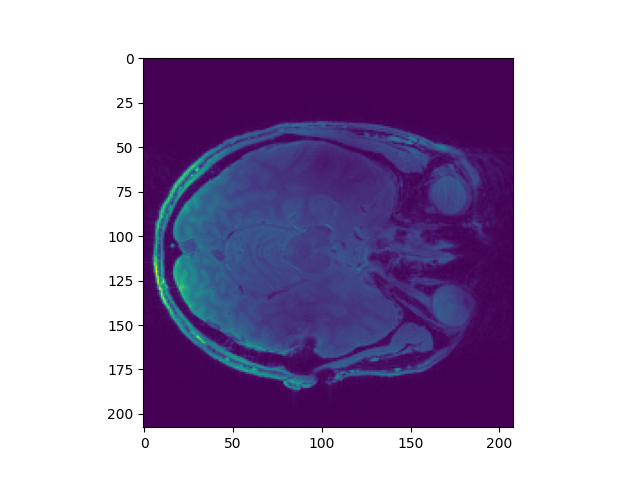

In [28]:
plt.figure()
plt.imshow(mag_data[:,:,10])

# **Brain Extraction Using U-Net**   (3D and Auto)

In [26]:
torch.tensor(0)

tensor(0)

In [5]:
deb = time.time()

for i in tqdm(range(208*208*96)):
    x = 1
fin  = time.time()


100%|██████████| 4153344/4153344 [00:01<00:00, 3665897.17it/s]


In [18]:
i,j,k = 0,0,0
Z = np.array(mag_data)
Z = Z.flatten()
values,n = np.unique(Z,return_counts=True)
proba = n/len(Z)

In [20]:
J = 1
eps = 0



0.9999999999999998